In [1]:
from scipy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
import scipy.sparse as sparse
from scipy.integrate import quad
import numpy as np
import pandas as pd
from scipy.sparse.linalg import splu
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [5]:
def rk23(dudt,tspan,u0,tol):
	"""
	rk23(dudt,tspan,u0,tol)

	Apply adaptive embedded RK formula to solve the vector-valued IVP u'=`dudt`(u,p,t)
	over the interval `tspan` with u(`tspan[1]`)=`u0`, with error tolerance `tol`.
	Return a vector of times and a vector of solution values/vectors.
	"""
	# Initialize for the first time step.
	t = [tspan[0]]
	u = [u0];   i = 0
	h = 0.5*tol**(1/3)
	s1 = dudt(t,u0)

	# Time stepping.
	while t[i] < tspan[-1]:
		# Detect underflow of the step size.
		if t[i]+h == t[i]:
			warnings.warn(f"Stepsize too small near t={t[i]}")
			break  # quit time stepping loop

		# New RK stages.
		s2 = dudt( t[i]+h/2,   u[i]+(h/2)*s1   )
		s3 = dudt( t[i]+3*h/4, u[i]+(3*h/4)*s2 )
		unew2 = u[i] + h*(2*s1 + 3*s2 + 4*s3)/9   # 2rd order solution
		s4 = dudt( t[i]+h , unew2 )
		err = h*(-5*s1/72 + s2/12 + s3/9 - s4/8)    # 2nd/3rd order difference
		E = np.linalg.norm(err,np.inf)                           # error estimate
		maxerr = tol*(1 + np.linalg.norm(u[i],np.inf))         # relative/absolute blend

		# Accept the proposed step?
		if E < maxerr:     # yes
			t.append(t[i] + h)
			u.append(unew2)
			i = i+1
			s1 = s4      # use FSAL property

		# Adjust step size.
		q = 0.8*(maxerr/E)**(1/3)       # conservative optimal step factor
		q = min(q,4)                    # limit stepsize growth
		h = min(q*h,tspan[-1]-t[i])      # don't step past the end

	# Convert outputs to arrays
	return np.array(t), np.array(u).T

# T1

Solving ODE for all initial conditions...
Done.


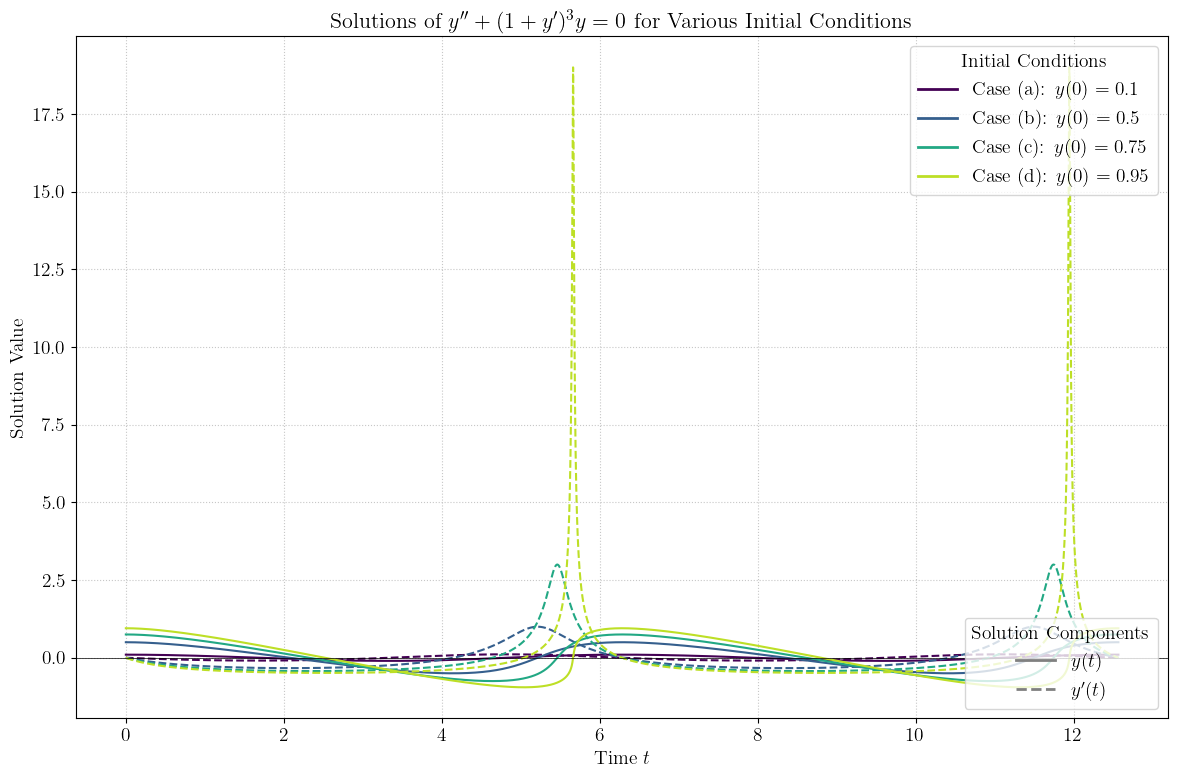

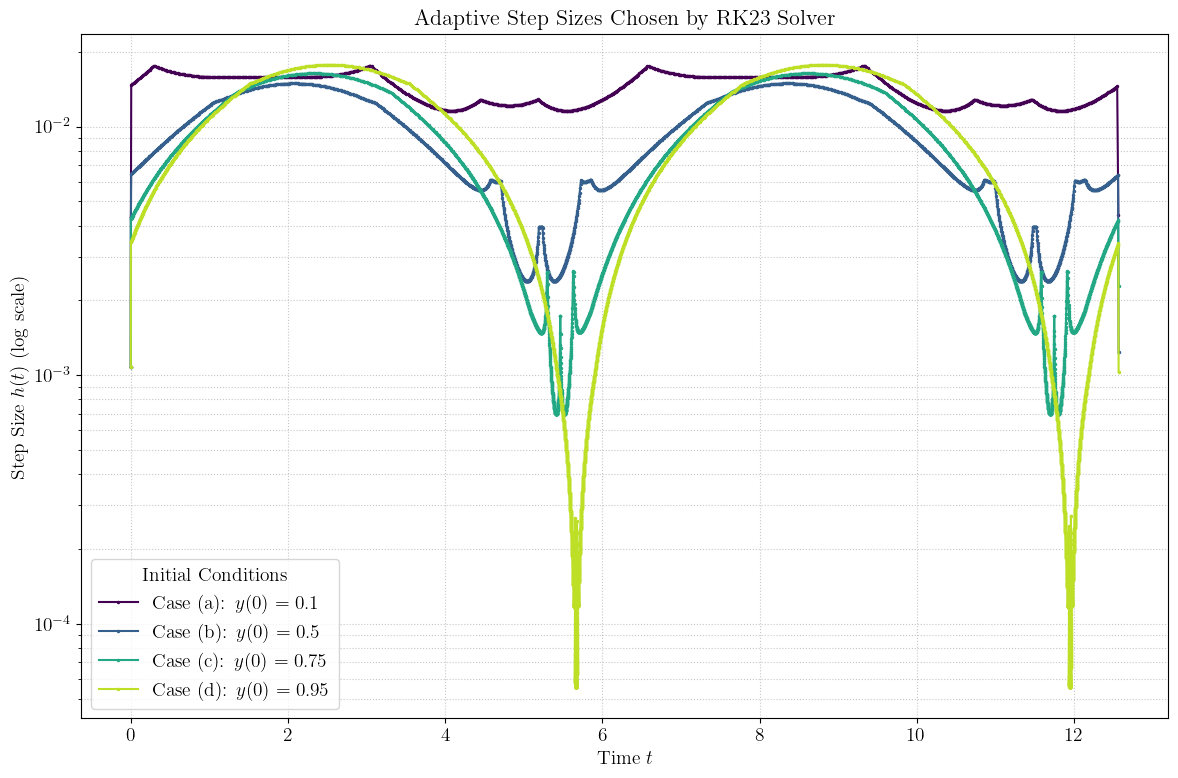

In [8]:
# ==============================================================================
# 1. ODE system definition
# ==============================================================================
def ode_system(t, u):
    u1, u2 = u
    du1_dt = u2
    du2_dt = -(1 + u2)**3 * u1
    return np.array([du1_dt, du2_dt])

# ==============================================================================
# 2. Main script for solving and plotting
# ==============================================================================
# --- Setup for professional plotting ---
try:
    plt.rcParams.update({
        "text.usetex": True, "font.family": "serif", 
        "font.serif": ["Computer Modern Roman"], "font.size": 14
    })
except RuntimeError:
    warnings.warn("LaTeX not found. Falling back to default matplotlib rendering.")
    plt.rcParams.update({"font.size": 14})

# --- Problem Parameters ---
tspan = [0, 4 * np.pi]
tol = 1e-8
initial_conditions = [
    (0.1, 0), (0.5, 0), (0.75, 0), (0.95, 0)
]
case_labels = [
    r'Case (a): $y(0)=0.1$', r'Case (b): $y(0)=0.5$',
    r'Case (c): $y(0)=0.75$', r'Case (d): $y(0)=0.95$'
]

# --- Scientific Color Palette (Viridis is great for ordered data) ---
colors = plt.cm.viridis(np.linspace(0, 0.9, len(initial_conditions)))

# --- Data Generation: Solve for all cases first ---
results = []
print("Solving ODE for all initial conditions...")
for i, u0_values in enumerate(initial_conditions):
    t_sol, u_sol = rk23(ode_system, tspan, np.array(u0_values), tol)
    results.append({
        't': t_sol,
        'y': u_sol[0, :],
        'y_prime': u_sol[1, :],
        'h': np.diff(t_sol),
        'label': case_labels[i],
        'color': colors[i]
    })
print("Done.")

# --- Plot 1: Solutions y(t) and y'(t) ---
fig1, ax1 = plt.subplots(figsize=(12, 8))
for res in results:
    ax1.plot(res['t'], res['y'], color=res['color'], linestyle='-')
    ax1.plot(res['t'], res['y_prime'], color=res['color'], linestyle='--')

# Create a custom legend
legend_cases = [Line2D([0], [0], color=res['color'], lw=2, label=res['label']) for res in results]
legend_styles = [
    Line2D([0], [0], color='gray', linestyle='-', lw=2, label=r'$y(t)$'),
    Line2D([0], [0], color='gray', linestyle='--', lw=2, label=r"$y'(t)$")
]
# Add the first legend (for cases) and then add the second one manually
leg1 = ax1.legend(handles=legend_cases, loc='upper right', title='Initial Conditions')
ax1.add_artist(leg1)
ax1.legend(handles=legend_styles, loc='lower right', title='Solution Components')

ax1.set_title(r"Solutions of $y'' + (1 + y')^3y = 0$ for Various Initial Conditions", fontsize=16)
ax1.set_xlabel(r'Time $t$')
ax1.set_ylabel(r'Solution Value')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.axhline(0, color='black', linewidth=0.5) # Add a line at y=0 for reference

# --- Plot 2: Time Step Sizes ---
fig2, ax2 = plt.subplots(figsize=(12, 8))
for res in results:
    ax2.semilogy(res['t'][:-1], res['h'], color=res['color'], label=res['label'], marker='.', markersize=3, linestyle='-')

ax2.set_title(r'Adaptive Step Sizes Chosen by RK23 Solver', fontsize=16)
ax2.set_xlabel(r'Time $t$')
ax2.set_ylabel(r'Step Size $h(t)$ (log scale)')
ax2.legend(title='Initial Conditions')
ax2.grid(True, which='both', linestyle=':', alpha=0.7) # Grid on major and minor ticks

# --- Display Plots ---
fig1.tight_layout()
fig2.tight_layout()
plt.show()

# T2

Solving FitzHugh-Nagumo system for different tolerances...
  Solving with tolerance = 1e-02...
  Solving with tolerance = 1e-03...
  Solving with tolerance = 1e-04...
Done.


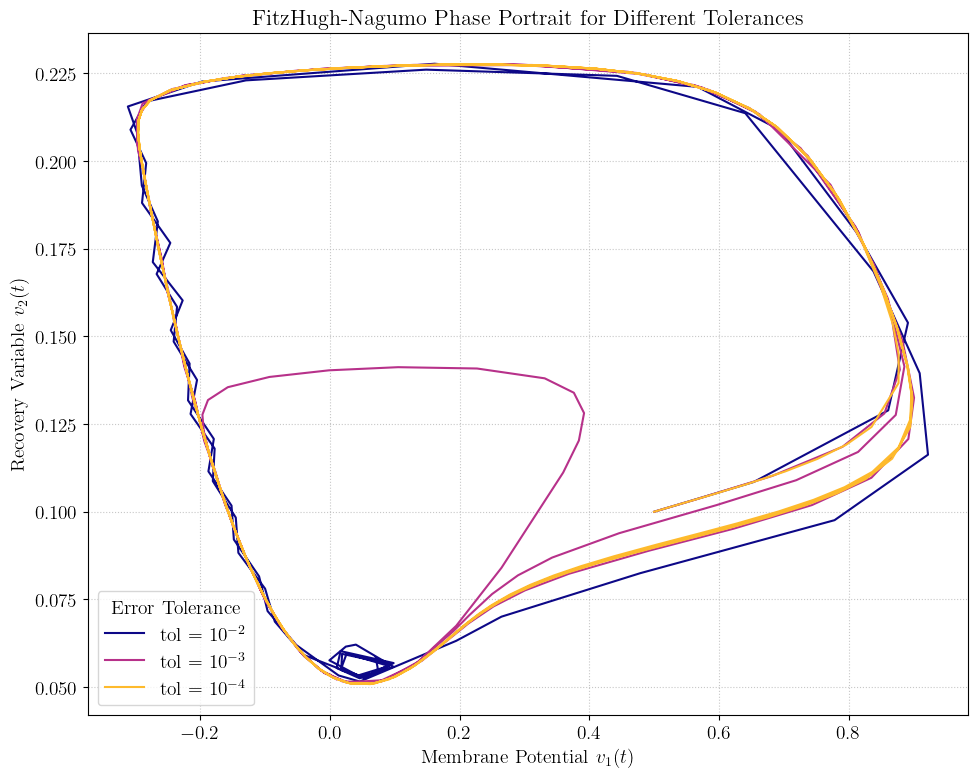

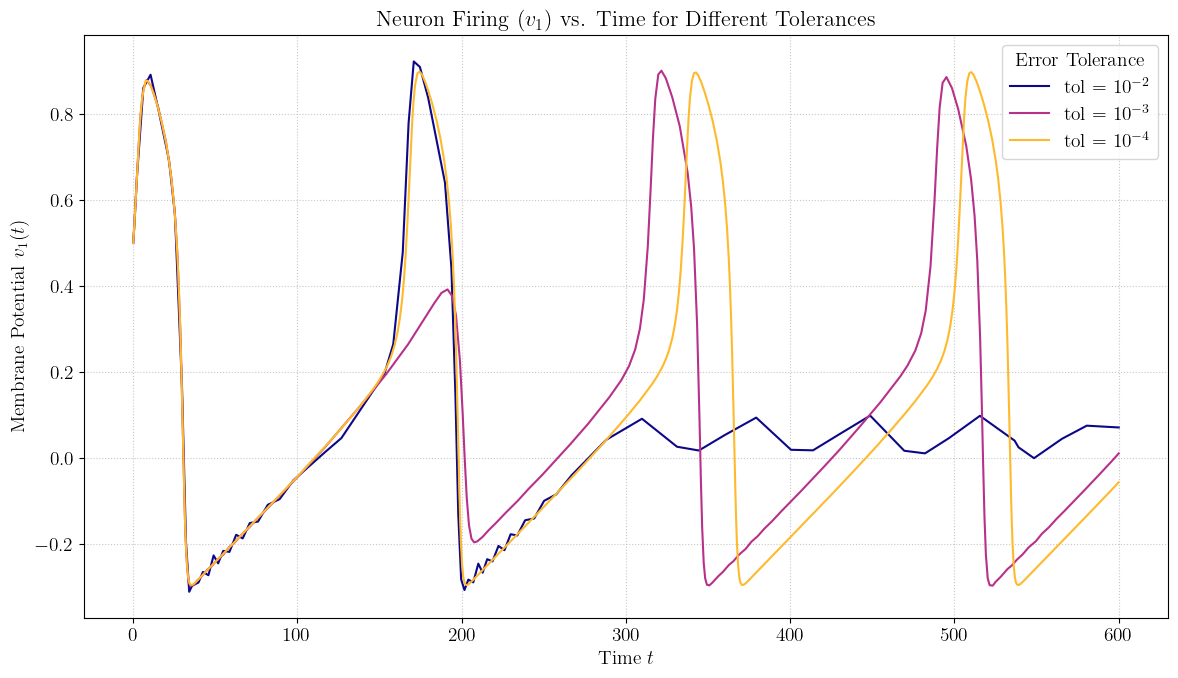

In [10]:
# ==============================================================================
# 1. Define the FitzHugh-Nagumo ODE system
# ==============================================================================
# --- System Parameters ---
A = 0.1
EPSILON = 0.008
GAMMA = 1.0
I_val = 0.05740

def fitzhugh_nagumo_system(t, u):
    """
    Defines the FitzHugh-Nagumo system of equations.
    u[0] = v1 (membrane potential)
    u[1] = v2 (recovery variable)
    """
    v1, v2 = u
    dv1_dt = -v1 * (v1 - 1.0) * (v1 - A) - v2 + I_val
    dv2_dt = EPSILON * (v1 - GAMMA * v2)
    return np.array([dv1_dt, dv2_dt])

# ==============================================================================
# 2. Main script for solving and plotting
# ==============================================================================
# --- Setup for professional plotting ---
try:
    plt.rcParams.update({
        "text.usetex": True, "font.family": "serif", 
        "font.serif": ["Computer Modern Roman"], "font.size": 14
    })
except RuntimeError:
    warnings.warn("LaTeX not found. Falling back to default matplotlib rendering.")
    plt.rcParams.update({"font.size": 14})
    
# --- Simulation Parameters ---
u0 = np.array([0.5, 0.1])
tspan = [0, 600]
tolerances = [1e-2, 1e-3, 1e-4]

# --- Scientific Color Palette (Plasma is good for ordered data) ---
colors = plt.cm.plasma(np.linspace(0, 0.85, len(tolerances)))

# --- Data Generation: Solve for all tolerances ---
results = []
print("Solving FitzHugh-Nagumo system for different tolerances...")
for i, tol in enumerate(tolerances):
    print(f"  Solving with tolerance = {tol:.0e}...")
    t_sol, u_sol = rk23(fitzhugh_nagumo_system, tspan, u0, tol)
    results.append({
        'tol': tol,
        't': t_sol,
        'v1': u_sol[0, :],
        'v2': u_sol[1, :],
        'color': colors[i],
        'label': f'tol = $10^{{{int(np.log10(tol))}}}$'
    })
print("Done.")

# --- Plot 1: Phase Portrait (v2 vs v1) ---
fig1, ax1 = plt.subplots(figsize=(10, 8))
for res in results:
    ax1.plot(res['v1'], res['v2'], color=res['color'], label=res['label'], lw=1.5)

ax1.set_title(r'FitzHugh-Nagumo Phase Portrait for Different Tolerances', fontsize=16)
ax1.set_xlabel(r'Membrane Potential $v_1(t)$')
ax1.set_ylabel(r'Recovery Variable $v_2(t)$')
ax1.legend(title='Error Tolerance')
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Time Series of Membrane Potential (v1 vs t) ---
fig2, ax2 = plt.subplots(figsize=(12, 7))
for res in results:
    ax2.plot(res['t'], res['v1'], color=res['color'], label=res['label'], lw=1.5)

ax2.set_title(r'Neuron Firing ($v_1$) vs. Time for Different Tolerances', fontsize=16)
ax2.set_xlabel(r'Time $t$')
ax2.set_ylabel(r'Membrane Potential $v_1(t)$')
ax2.legend(title='Error Tolerance')
ax2.grid(True, linestyle=':', alpha=0.7)

# --- Display Plots ---
fig1.tight_layout()
fig2.tight_layout()
plt.show()

# T4

Solving the stiff ODE...
Done.


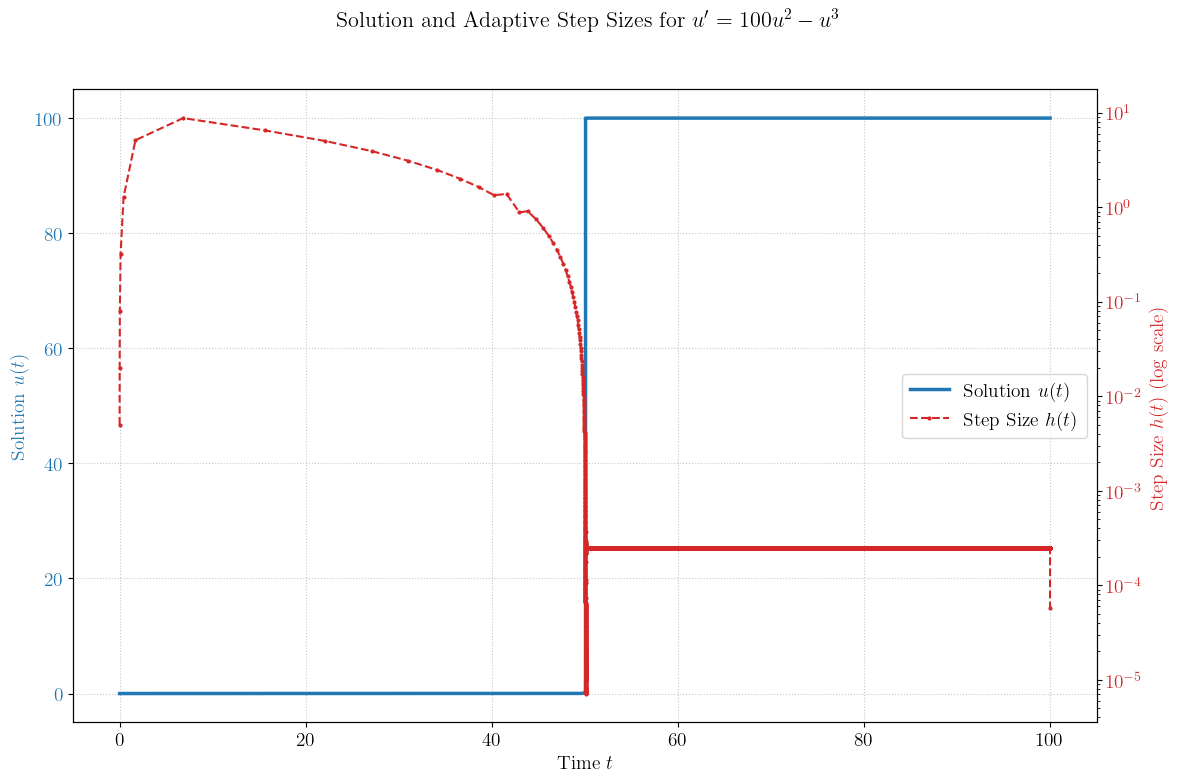

In [12]:
# ==============================================================================
# 1. Define the "stiff" ODE
# ==============================================================================
def stiff_ode(t, u):
    """
    Defines the problem u' = 100*u^2 - u^3.
    Note: u is a scalar here, but we treat it as a NumPy array inside rk23.
    """
    return 100 * u**2 - u**3

# ==============================================================================
# 2. Main script for solving and plotting
# ==============================================================================
# --- Setup for professional plotting ---
try:
    plt.rcParams.update({
        "text.usetex": True, "font.family": "serif", 
        "font.serif": ["Computer Modern Roman"], "font.size": 14
    })
except RuntimeError:
    warnings.warn("LaTeX not found. Falling back to default matplotlib rendering.")
    plt.rcParams.update({"font.size": 14})

# --- Simulation Parameters ---
u0 = np.array([0.0002]) # Initial condition as a NumPy array
tspan = [0, 100]
tol = 1e-6

# --- Solve the ODE ---
print("Solving the stiff ODE...")
t_sol, u_sol_2d = rk23(stiff_ode, tspan, u0, tol)
u_sol = u_sol_2d.flatten()  # <-- ADD THIS LINE to convert (1, N) to (N,)
print("Done.")
# print("Solving the stiff ODE...")
# t_sol, u_sol = rk23(stiff_ode, tspan, u0, tol)
# print("Done.")

# Calculate step sizes
step_sizes = np.diff(t_sol)

# --- Create the combined plot ---
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the solution u(t) on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel(r'Time $t$')
ax1.set_ylabel(r'Solution $u(t)$', color=color1)
line1, = ax1.plot(t_sol, u_sol, color=color1, lw=2.5, label=r'Solution $u(t)$')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle=':', alpha=0.7)

# Create a secondary y-axis for the step sizes
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel(r'Step Size $h(t)$ (log scale)', color=color2)
# Use semilogy on the secondary axis by plotting on it directly
line2, = ax2.plot(t_sol[:-1], step_sizes, color=color2, linestyle='--', marker='.', markersize=4, label=r'Step Size $h(t)$')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_yscale('log') # Set the secondary axis to log scale

# --- Final Touches ---
fig.suptitle(r"Solution and Adaptive Step Sizes for $u' = 100u^2 - u^3$", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle

# Add a combined legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.show()